In [1]:
import os

data_dir = '../data/paper_final_results'
os.listdir(data_dir)

['accuracy_seeds', 'arch2vec_orig_seeds', 'baselines', 'info-nas_seeds']

In [2]:
def process_res_dict(path, seed, algo, model, what='test'):
    with open(os.path.join(path, f'Test features - {what} accuracy_metrics.txt'), 'r') as f:
        res_dict = {}
        for l in f:
            l = l.split(': ')
            key = l[0]
            val = l[1].replace('(', '').replace(')', '').split(', ')[0]

            res_dict[key] = float(val)
            
        res_dict['seed'] = seed
        res_dict['algo'] = algo
        res_dict['model'] = model
    
    return res_dict

In [3]:
import glob

what = 'test'
res_df = []

for train_seed in range(1, 4):
    for samples in [608, 1000, 2500, 5000, 10000]:
        for seed in range(10):
            for algo in ['accuracy', 'info-nas', 'arch2vec_orig']:
                for model in ['model_dense', 'model_orig', 'model_ref']:
                    if 'ref' in model and 'acc' in algo:
                        continue
                    if algo == 'arch2vec_orig':
                        if train_seed != 1 or 'ref' not in model:
                            continue
                        a2v_name = 'features-original_training_arch2vec_epochs-8.pt'
                        p = os.path.join(data_dir,
                                         f'{algo}_seeds',
                                         f'seed_{train_seed}', 'regr',
                                         f'rf_tune_{samples}_{seed + 1}_train_{a2v_name}')
                    else:
                        p = os.path.join(data_dir,
                                         f'{algo}_seeds',
                                         f'seed_{train_seed}', 'regr',
                                         f'rf_tune_{samples}_{seed + 1}_train_embedding_{model}_epoch-9.pt')

                    res = process_res_dict(p, seed, algo, model, what=what)
                    res['samples'] = samples
                    res['train_seed'] = train_seed
                    res_df.append(res)

In [4]:
import pandas as pd

res_df = pd.DataFrame(res_df)
results_table = res_df[['model', 'algo', 'RMSE', 'Pearson\'s r']].groupby(
    ['algo', 'model']).std().round(2)

In [5]:
values_map = {
    'accuracy': {
        'model_dense': 'Accuracy Model 1',
        'model_orig': 'Accuracy Model 2'
    },
    'info-nas': {
        'model_dense': 'IO Model 1',
        'model_orig': 'IO Model 2',
        'model_ref': 'arch2vec'
    },
    'arch2vec_orig': {
        'model_ref': 'arch2vec original'
    }
}

res_df['Used model'] = ""
for i in range(len(res_df)):
    row = res_df.iloc[i]
    res_df.loc[row.name, 'Used model'] = values_map[row['algo']][row['model']]
res_df

,RMSE,Pearson's r,seed,algo,model,samples,train_seed,Used model
0,0.017068,0.632822,0,accuracy,model_dense,608,1,Accuracy Model 1
1,0.017259,0.673271,0,accuracy,model_orig,608,1,Accuracy Model 2
2,0.016963,0.667180,0,info-nas,model_dense,608,1,IO Model 1
3,0.017517,0.686060,0,info-nas,model_orig,608,1,IO Model 2
4,0.018357,0.673996,0,info-nas,model_ref,608,1,arch2vec
...,...,...,...,...,...,...,...,...
795,0.018768,0.761229,9,accuracy,model_dense,10000,3,Accuracy Model 1
796,0.022250,0.673712,9,accuracy,model_orig,10000,3,Accuracy Model 2
797,0.020858,0.714704,9,info-nas,model_dense,10000,3,IO Model 1
798,0.022808,0.678182,9,info-nas,model_orig,10000,3,IO Model 2


In [6]:
orig_res_df = res_df.copy()

In [7]:

ts = 3
res_df = orig_res_df[orig_res_df['samples'].isin([608, 2500, 10000]) & ((orig_res_df['train_seed'] == ts) | (orig_res_df['algo'] == 'arch2vec_orig'))]

In [8]:
res_df

,RMSE,Pearson's r,seed,algo,model,samples,train_seed,Used model
5,0.018474,0.609542,0,arch2vec_orig,model_ref,608,1,arch2vec original
11,0.017912,0.627930,1,arch2vec_orig,model_ref,608,1,arch2vec original
17,0.018753,0.600953,2,arch2vec_orig,model_ref,608,1,arch2vec original
23,0.018599,0.612789,3,arch2vec_orig,model_ref,608,1,arch2vec original
29,0.018566,0.601324,4,arch2vec_orig,model_ref,608,1,arch2vec original
...,...,...,...,...,...,...,...,...
795,0.018768,0.761229,9,accuracy,model_dense,10000,3,Accuracy Model 1
796,0.022250,0.673712,9,accuracy,model_orig,10000,3,Accuracy Model 2
797,0.020858,0.714704,9,info-nas,model_dense,10000,3,IO Model 1
798,0.022808,0.678182,9,info-nas,model_orig,10000,3,IO Model 2


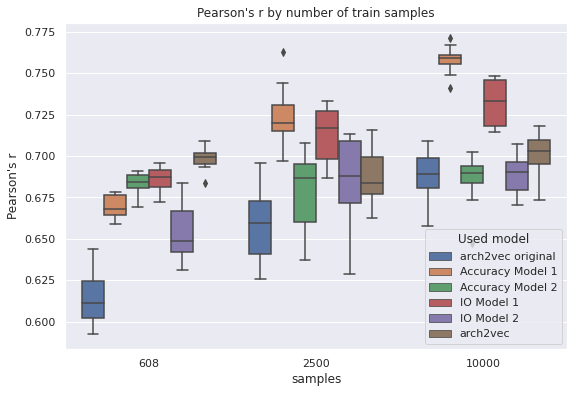

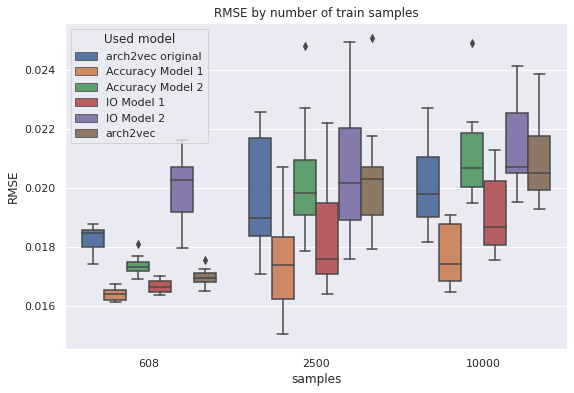

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

save_dir = '.'

plt.figure(figsize=(9,6))
plt.title('Pearson\'s r by number of train samples')
sns.boxplot(data=res_df, x='samples', y='Pearson\'s r', hue='Used model')
plt.savefig(f'{save_dir}/pearson.png')
plt.show()

plt.figure(figsize=(9,6))
plt.title('RMSE by number of train samples')
sns.boxplot(data=res_df, x='samples', y='RMSE', hue='Used model')
plt.savefig(f'{save_dir}/rmse.png')
plt.show()

In [16]:
n_samples = 10000

In [17]:
res_df[res_df['samples'] == n_samples].groupby(['Used model', 'samples']).mean().round(4)

,,RMSE,Pearson's r,seed,train_seed
Used model,samples,,,,
Accuracy Model 1,10000,0.0177,0.7581,4.5,3.0
Accuracy Model 2,10000,0.0211,0.6862,4.5,3.0
IO Model 1,10000,0.0191,0.7323,4.5,3.0
IO Model 2,10000,0.0214,0.6897,4.5,3.0
arch2vec,10000,0.0209,0.7010,4.5,3.0
arch2vec original,10000,0.0201,0.6879,4.5,1.0


In [18]:
import numpy as np

(1.96 / np.sqrt(10) * res_df[res_df['samples'] == n_samples].groupby(['Used model', 'samples']).std()).round(4)

,,RMSE,Pearson's r,seed,train_seed
Used model,samples,,,,
Accuracy Model 1,10000,0.0006,0.0053,1.8766,0.0
Accuracy Model 2,10000,0.0010,0.0100,1.8766,0.0
IO Model 1,10000,0.0008,0.0089,1.8766,0.0
IO Model 2,10000,0.0009,0.0077,1.8766,0.0
arch2vec,10000,0.0009,0.0079,1.8766,0.0
arch2vec original,10000,0.0009,0.0094,1.8766,0.0
